In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 10]

User-ID:
3c2d928b72ce20100406634b07ea19
Matthias:
adf4e79ed61d5fa242f62828c1ec36

In [2]:
path_train = "data/train.csv"
path_qualifying = "data/qualifying_blanc.csv"

In [3]:
data_train = np.genfromtxt(path_train, delimiter=",", dtype=np.int, encoding="utf-8")
data_qualifying = np.genfromtxt(path_qualifying, delimiter=",", dtype=np.int, encoding="utf-8")

In [4]:
users_train = set(data_train[:,0])
users_qualifying = set(data_qualifying[:,0])
print("T:     ", len(users_train))
print("Q:     ", len(users_qualifying))
print("T & Q: ", len(users_train & users_qualifying))
print("T - Q  ", len(users_train - users_qualifying))
print("Q - T  ", len(users_qualifying - users_train))

T:      1666
Q:      1513
T & Q:  1505
T - Q   161
Q - T   8


In [5]:
print(data_qualifying)
print(data_train)

[[ 272 1242]
 [ 687 1257]
 [ 599  849]
 ...
 [1164 1111]
 [ 277  396]
 [1031  517]]
[[   2  566    1]
 [   2  750    2]
 [   2  391    1]
 ...
 [5498  565    2]
 [5498  648    2]
 [5498  651    2]]


In [6]:
X = np.zeros(shape=(max(data_train[:,0]) + 1, max(data_train[:,1]) + 1))

In [7]:
for i,j,k in data_train:
   X[i,j] = k + 1

In [8]:
# density
len(data_train) / np.prod(X.shape)

0.03800000349713934

In [9]:
# create idx map
X_full = np.copy(X)
idx_rows = np.sum(X, axis=1) != 0
idx_cols = np.sum(X, axis=0) != 0
X = X[idx_rows][:, idx_cols]
idx_rows = idx_rows.astype(int).reshape(idx_rows.shape[0], 1)
idx_cols = idx_cols.astype(int).reshape(idx_cols.shape[0], 1)
idx = np.dot(idx_rows, idx_cols.T).astype(bool)

In [10]:
# test idx map
X_full_test = np.zeros(X_full.shape)
X_full_test[idx] = X.flatten()
assert np.array_equal(X_full, X_full_test)

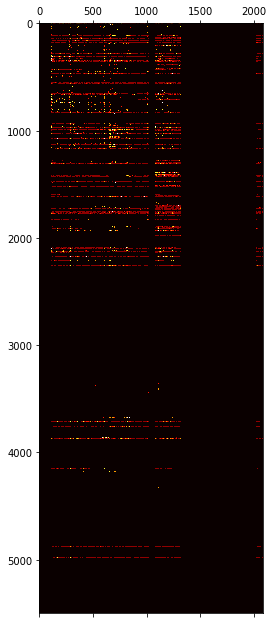

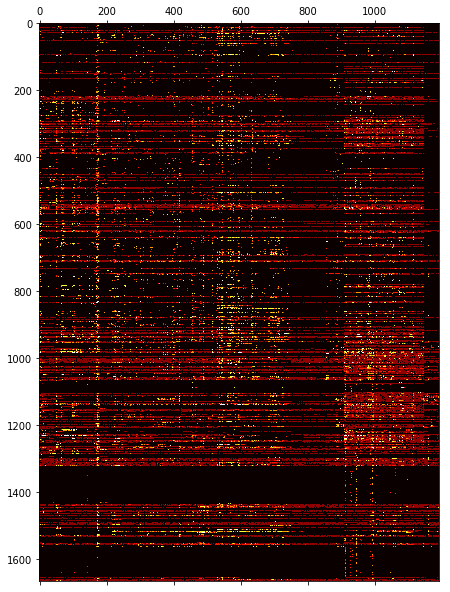

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.matshow(X_full, cmap=plt.cm.hot)
plt.matshow(X, cmap=plt.cm.hot);

In [12]:
def means(X, axis="row"):
    if axis == "row":
        X_local = X
    elif axis == "col":
        X_local = X.T
    else:
        raise Exception("Unknown axis!")
    X_complete = np.copy(X_local)
    for i, row in enumerate(X_local):
        mean = np.sum(row) / np.sum(row != 0)
        X_complete[i][X_local[i] == 0] = mean
    X_complete = X_complete.T if axis == "col" else X_complete
    return X_complete

In [13]:
def mostFrequent(X, axis="row"):
    if axis == "row":
        X_local = X
    elif axis == "col":
        X_local = X.T
    else:
        raise Exception("Unknown axis!")
    X_local = X_local.astype(int)
    X_complete = np.copy(X_local.view(np.int))
    for i, row in enumerate(X_local):
        X_complete[i][X_local[i] == 0] = np.bincount(row).argmax()
    X_complete = X_complete.T if axis == "col" else X_complete
    return X_complete

In [14]:
def completeQualifyingFromMatrix(data_qualifying, X, X_full, idx):
    X_full_local = np.copy(X_full)
    X_full_local[idx] = X.flatten()
    predictions = []
    for i,j in data_qualifying:
        predictions.append(X_full_local[i,j] - 1)
    return np.c_[data_qualifying, np.array(predictions)]

In [15]:
X_rm = means(X, axis="row")
X_cm = means(X, axis="col")
dq_rm = completeQualifyingFromMatrix(data_qualifying, X_rm, X_full, idx)
dq_cm = completeQualifyingFromMatrix(data_qualifying, X_cm, X_full, idx)
np.savetxt("qualifying_row_mean.csv", dq_rm, delimiter=",", newline="\n", encoding="utf-8")
np.savetxt("qualifying_col_mean.csv", dq_cm, delimiter=",", newline="\n", encoding="utf-8")

In [16]:
X_mfr = mostFrequent(X, axis="row")
X_mfc = mostFrequent(X, axis="col")
dq_mfr = completeQualifyingFromMatrix(data_qualifying, X_mfr, X_full, idx)
dq_mfc = completeQualifyingFromMatrix(data_qualifying, X_mfc, X_full, idx)
np.savetxt("qualifying_row_most_frequent.csv", dq_mfr, delimiter=",", newline="\n", encoding="utf-8")
np.savetxt("qualifying_col_most_frequent.csv", dq_mfc, delimiter=",", newline="\n", encoding="utf-8")

In [17]:
#from surprise import BaselineOnly
#from surprise import Dataset
#from surprise import Reader

# datapoints with offset: train_surprise.csv
#path_train = "train_surprise.csv"
#path_train = "data/train.csv"
#reader = Reader(line_format='user item rating', sep=',')

#data = Dataset.load_from_file(path_train, reader=reader)

In [18]:
import pandas as pd
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader

# datapoints with offset: train_surprise.csv
path_train = "train_surprise.csv"
path_train = "data/train.csv"

ratings_dict = {'itemID': data_train[:,1],
                'userID': data_train[:,0],
                'rating': data_train[:,2] + 1}
df = pd.DataFrame(ratings_dict)
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)


/home/matthias/anaconda3/lib/python3.6/site-packages/scikit_surprise-1.0.6-py3.6-linux-x86_64.egg/surprise/dataset.py:61: UserWarning: Using rating_scale from reader, deprecated. Set rating_scale at dataset creationg instead (load_from_file, load_from_folds, or load_from_df).
  warnings.warn('Using rating_scale from reader, deprecated. Set '


In [19]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=0.25)
fullset = data.build_full_trainset()

In [20]:
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import accuracy

for algo_mod in [KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline]:
    algo = algo_mod(k=10, verbose=False)

    algo.fit(trainset)
    predictions = algo.test(testset)
    #print(predictions)
    print(str(algo_mod), "\n", accuracy.rmse(predictions))

RMSE: 0.5805
<class 'surprise.prediction_algorithms.knns.KNNBasic'> 
 0.5804514799672827
RMSE: 0.5840
<class 'surprise.prediction_algorithms.knns.KNNWithMeans'> 
 0.5840160737026048
RMSE: 0.5780
<class 'surprise.prediction_algorithms.knns.KNNWithZScore'> 
 0.5779573440293568
RMSE: 0.5694
<class 'surprise.prediction_algorithms.knns.KNNBaseline'> 
 0.5694042428926228


In [21]:
algo = KNNBasic(k=10, verbose=True)
algo.fit(fullset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [22]:
for user, item in data_qualifying[100:105]:
    print(algo.predict(user, item))

user: 619        item: 319        r_ui = None   est = 1.00   {'actual_k': 10, 'was_impossible': False}
user: 3363       item: 1159       r_ui = None   est = 2.40   {'actual_k': 10, 'was_impossible': False}
user: 1784       item: 1258       r_ui = None   est = 1.10   {'actual_k': 10, 'was_impossible': False}
user: 756        item: 1222       r_ui = None   est = 1.10   {'actual_k': 10, 'was_impossible': False}
user: 3760       item: 919        r_ui = None   est = 1.00   {'actual_k': 10, 'was_impossible': False}


In [23]:
from surprise import NormalPredictor
from surprise import SlopeOne
from surprise import CoClustering
from surprise import BaselineOnly
from surprise import accuracy
for algo_mod in [SlopeOne, CoClustering, NormalPredictor, BaselineOnly]:
    algo = algo_mod()

    algo.fit(trainset)
    predictions = algo.test(testset)

    print(str(algo_mod), "\n", accuracy.rmse(predictions))

RMSE: 0.6522
<class 'surprise.prediction_algorithms.slope_one.SlopeOne'> 
 0.6522077564924883
RMSE: 0.6405
<class 'surprise.prediction_algorithms.co_clustering.CoClustering'> 
 0.6405188483036484
RMSE: 1.0541
<class 'surprise.prediction_algorithms.random_pred.NormalPredictor'> 
 1.0540866800149398
Estimating biases using als...
RMSE: 0.6592
<class 'surprise.prediction_algorithms.baseline_only.BaselineOnly'> 
 0.6592406149336854


In [24]:
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import accuracy
# We'll use the famous SVD algorithm.
for algo_mod in [SVD, NMF, SVDpp]:
    algo = algo_mod()

    algo.fit(trainset)
    predictions = algo.test(testset)
    #print(predictions)
    print(str(algo_mod), "\n", accuracy.rmse(predictions))

RMSE: 0.5174
<class 'surprise.prediction_algorithms.matrix_factorization.SVD'> 
 0.5174370334792456
RMSE: 0.5761
<class 'surprise.prediction_algorithms.matrix_factorization.NMF'> 
 0.5760914016920085
RMSE: 0.5213
<class 'surprise.prediction_algorithms.matrix_factorization.SVDpp'> 
 0.521283561020481


In [ ]:
def completeQualifyingSurpriseAlgo(data_qualifying, algo):
    predictions = []
    for user, item in data_qualifying:
        p = algo.predict(user, item)
        rating = p.est - 1
        predictions.append(rating)
    return np.c_[data_qualifying, np.array(predictions)]

In [ ]:
def completeQualifyingSurpriseFull(trainset, data_qualifying, algo_mod):
    algo = algo_mod()
    name = str(algo).split(".")[-1].split("object")[0]
    algo.fit(trainset)
    dq_surprise = completeQualifyingSurpriseAlgo(data_qualifying, algo)
    np.savetxt("{}.csv".format(name), dq_surprise, delimiter=",", newline="\n", encoding="utf-8")

In [ ]:
completeQualifyingSurpriseFull(trainset, data_qualifying, KNNBasic)

In [ ]:
algo = SlopeOne()
algo.fit(trainset)
dq_s_slope = completeQualifyingSurpriseAlgo(data_qualifying, algo)
np.savetxt("qualifying_surprise_slope.csv", dq_s_slope, delimiter=",", newline="\n", encoding="utf-8")

In [ ]:
dq_s_knn = completeQualifyingSurpriseAlgo(data_qualifying, algo)
np.savetxt("qualifying_surprise_knn.csv", dq_s_knn, delimiter=",", newline="\n", encoding="utf-8")

In [ ]:
reader = Reader(line_format='user item', sep=',')
qualifying_set = Dataset.load_from_file(path_qualifying, reader=reader)

In [109]:
###################################################################################################
import time
algos = [KNNWithZScore(k=10, verbose=False),
         KNNBasic(k=10, verbose=False),
         KNNWithMeans(k=10, verbose=False),
         KNNBaseline(k=10, verbose=False),
         SlopeOne(),
         CoClustering(),
         NMF(),
         #SVDpp(),
         SVD(),
         BaselineOnly()]
for algo in algos:
    start = time.time()
    algo.fit(trainset)
    end = time.time()
    print(str(algo), end - start, flush=True)

<surprise.prediction_algorithms.knns.KNNWithZScore object at 0x7fe0aea2b0f0> 2.534123420715332
<surprise.prediction_algorithms.knns.KNNBasic object at 0x7fe0aea2b128> 2.3012075424194336
<surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7fe0aea2b160> 2.3576560020446777
<surprise.prediction_algorithms.knns.KNNBaseline object at 0x7fe0aea2b198> 3.1232285499572754
<surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7fe0aea2b1d0> 6.223627805709839
<surprise.prediction_algorithms.co_clustering.CoClustering object at 0x7fe0aea2b208> 5.067956924438477
<surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7fe0aea2b240> 19.245875597000122
<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fe0aea2b278> 16.078158855438232
Estimating biases using als...
<surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x7fe0aea2b2b0> 0.8716228008270264


In [ ]:
###################################################################################################

In [132]:
algos = [#KNNWithZScore(k=10, verbose=False),
         KNNBasic(k=10, verbose=False),
         #KNNWithMeans(k=10, verbose=False),
         #KNNBaseline(k=10, verbose=False),
         #SlopeOne(),
         #CoClustering(),
         NMF(),
         #SVDpp(),
         SVD(),
         #BaselineOnly()
         ]
algos = [algo.fit(trainset) for algo in algos]

In [133]:
predictions = [algo.test(testset) for algo in algos]

In [134]:
ps = []
for i in predictions:
    p = []
    for j in i:
        p.append(j.est)
    ps.append(np.array(p))

In [135]:
predictions = ps

In [136]:
predictions_test = np.array(testset)[:,-1]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def objective(x):
    ps = [x[i]*predictions[i] for i in range(len(x))]
    ps = np.sum(ps, axis=0)
    return rmse(ps, predictions_test)

In [137]:
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

x = np.random.rand(len(predictions))
x = x / np.sum(x)
# COBYLA, SLSQP, trust-constr
method = "SLSQP"
res = minimize(objective, 
               x,
               method=method,
               constraints = [{'type':'eq', 'fun': lambda x: np.sum(x) - 1}])
print(res.x, sum(res.x))

[ 0.24959111 -0.43539784  1.18580673] 0.9999999999999999


In [138]:
x = res.x
algos = [algo.fit(fullset) for algo in algos]
predictions = []
for user, item in data_qualifying:
    psum = []
    for algo in algos:
        psum.append(algo.predict(user, item).est)
    psum = psum * x
    rating = np.sum(psum) - 1
    predictions.append(rating)

final_predictions = np.c_[data_qualifying, np.array(predictions)]
np.savetxt("final_prediction.csv", final_predictions, delimiter=",", newline="\n", encoding="utf-8")

In [139]:
final_predictions = np.c_[data_qualifying, np.array(predictions)]
np.savetxt("final_prediction.csv", final_predictions, delimiter=",", newline="\n", encoding="utf-8")

In [140]:
np.savetxt("final_prediction_{}.csv".format(method),
           final_predictions, delimiter=",", newline="\n", encoding="utf-8")